In [1]:
! pip install transformers plotly datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.7 MB/s eta 0:00:00


In [2]:
! rm -rf space-model
! rm -rf nano-BERT
! git clone https://github.com/StepanTita/space-model.git
! git clone https://github.com/StepanTita/nano-BERT.git

Cloning into 'space-model'...
remote: Enumerating objects: 128, done.
remote: Counting objects: 100% (128/128), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 128 (delta 33), reused 111 (delta 19), pack-reused 0
Receiving objects: 100% (128/128), 29.56 MiB | 21.26 MiB/s, done.
Resolving deltas: 100% (33/33), done.
Cloning into 'nano-BERT'...
remote: Enumerating objects: 56, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 56 (delta 25), reused 30 (delta 8), pack-reused 0
Receiving objects: 100% (56/56), 39.04 MiB | 18.79 MiB/s, done.
Resolving deltas: 100% (25/25), done.
Updating files: 100% (11/11), done.


In [1]:
import sys

sys.path.append('space-model')

In [2]:
import math
import json
from collections import Counter
import random
import os

import pandas as pd
import numpy as np

import torch
import torch.nn.functional as F

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

from tqdm import tqdm

import matplotlib.pyplot as plt
import plotly.graph_objects as go

from transformers import AutoModel, AutoTokenizer, AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding

from datasets import load_dataset, Dataset, DatasetDict

from space_model.model import *
from space_model.loss import *

In [3]:
SEED = 42

In [4]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed=SEED)

In [5]:
def on_gpu(f):
    def wrapper(*args):
        if torch.cuda.is_available():
            return f(*args)
        else:
            print('cuda unavailable')
    return wrapper

In [6]:
if torch.cuda.is_available():
    ! pip install pynvml
    from pynvml import *
    from numba import cuda

@on_gpu
def print_gpu_utilization(dev_id):
    try:
        nvmlInit()
        handle = nvmlDeviceGetHandleByIndex(dev_id)
        info = nvmlDeviceGetMemoryInfo(handle)
        print(f"GPU memory occupied: {info.used//1024**2} MB.")
    except Exception as e:
        print(e)

@on_gpu
def free_gpu_cache(dev_id=0):
    print("Initial GPU Usage")
    print_gpu_utilization(dev_id)

    torch.cuda.empty_cache()

    print("GPU Usage after emptying the cache")
    print_gpu_utilization(dev_id)

def print_summary(result):
    print(f"Time: {result.metrics['train_runtime']:.2f}")
    print(f"Samples/second: {result.metrics['train_samples_per_second']:.2f}")
    print_gpu_utilization()

In [7]:
device_id = 0

In [8]:
device = torch.device(f'cuda:{device_id}' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [9]:
torch.cuda.set_device(device)

In [10]:
MODEL_NAME = 'bert-base-uncased'
MODELS_PATH = 'models'
DATASET_NAME = 'water_crisis'

NUM_LABELS = 2

NUM_EPOCHS = 1
BATCH_SIZE = 32
MAX_SEQ_LEN = 256
LEARNING_RATE = 2e-4
MAX_GRAD_NORM = 1000

In [11]:
data = pd.read_csv('./space-model/data/final_dataset.csv')
data

,sentences,attribution,attrib_words
0,a climate shift is happening,1,climate change
1,we need to take some serious steps as a nation,0,desalination
2,otherwise hard times are coming,0,government inaction
3,its your leadership like karunanidhi select go...,1,government inaction
4,god religion temples rituals religous sentimen...,1,climate change
...,...,...,...
5619,the lower the number the more amount of money ...,0,natural calamities
5620,we are destroying our nature then what can we ...,1,human activity
5621,good msg for save waters in world by arre\n,0,natural calamities
5622,yes lets pray for them to get water,0,deforestation


In [12]:
data = data.rename({'sentences': 'text', 'attribution': 'label'}, axis=1)
data

,text,label,attrib_words
0,a climate shift is happening,1,climate change
1,we need to take some serious steps as a nation,0,desalination
2,otherwise hard times are coming,0,government inaction
3,its your leadership like karunanidhi select go...,1,government inaction
4,god religion temples rituals religous sentimen...,1,climate change
...,...,...,...
5619,the lower the number the more amount of money ...,0,natural calamities
5620,we are destroying our nature then what can we ...,1,human activity
5621,good msg for save waters in world by arre\n,0,natural calamities
5622,yes lets pray for them to get water,0,deforestation


In [13]:
dataset = DatasetDict({
    'train': Dataset.from_list(data.to_dict('records'))
})
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'attrib_words'],
        num_rows: 5624
    })
})

In [14]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer

BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [15]:
train_split, test_split = train_test_split(dataset['train'], test_size=0.2, random_state=SEED)

In [16]:
dataset['test'] = Dataset.from_dict(test_split)

test_split, val_split = train_test_split(dataset['test'], test_size=0.5, random_state=SEED)

In [17]:
dataset['train'] = Dataset.from_dict(train_split)
dataset['test'] = Dataset.from_dict(test_split)
dataset['val'] = Dataset.from_dict(val_split)
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'attrib_words'],
        num_rows: 4499
    })
    test: Dataset({
        features: ['text', 'label', 'attrib_words'],
        num_rows: 562
    })
    val: Dataset({
        features: ['text', 'label', 'attrib_words'],
        num_rows: 563
    })
})

In [18]:
tokenized_dataset = dataset.map(lambda x: tokenizer(x['text'], truncation=True, padding='max_length', max_length=MAX_SEQ_LEN, return_tensors='pt'), batched=True)
tokenized_dataset.set_format('torch', device=device)
tokenized_dataset

Map:   0%|          | 0/4499 [00:00<?, ? examples/s]

Map:   0%|          | 0/562 [00:00<?, ? examples/s]

Map:   0%|          | 0/563 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'attrib_words', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4499
    })
    test: Dataset({
        features: ['text', 'label', 'attrib_words', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 562
    })
    val: Dataset({
        features: ['text', 'label', 'attrib_words', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 563
    })
})

In [19]:
base_model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME).to(device)
base_model

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [20]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [21]:
# for p in base_model.bert.parameters():
    # p.requires_grad = False
# for p in base_model.pre_classifier.parameters():
#     p.requires_grad = True

In [22]:
count_parameters(base_model)

109483778

In [23]:
def eval(f):
    def wrapper(model, *args, **kwargs):
        model.eval()
        return f(model, *args, **kwargs)
    return wrapper

def train(f):
    def wrapper(model, *args, **kwargs):
        model.train()
        return f(model, *args, **kwargs)
    return wrapper

In [24]:
@train
def train_epoch(model, train_dataloader, optimizer):
    train_loss = 0.0
    train_preds = []
    train_labels = []

    for step, batch in enumerate(tqdm(train_dataloader, total=len(train_dataloader))):
        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        targets = batch['label'].to(device, dtype = torch.long)

        outputs = model(input_ids=ids, attention_mask=mask, labels=targets) # (B, Seq_Len, 2)

        loss, logits = outputs.loss, outputs.logits

        probs = F.softmax(logits, dim=-1).cpu()
        pred = torch.argmax(probs, dim=-1) # (B)
        train_preds += pred.detach().tolist()
        train_labels += [l.item() for l in targets.cpu()]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    return train_loss, train_preds, train_labels

@eval
def eval_epoch(model, val_dataloader):
    val_loss = 0.0
    val_preds = []
    val_labels = []

    with torch.no_grad():

        for step, batch in enumerate(tqdm(val_dataloader, total=len(val_dataloader))):
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            targets = batch['label'].to(device, dtype = torch.long)

            outputs = model(input_ids=ids, attention_mask=mask, labels=targets)

            loss, logits = outputs.loss, outputs.logits

            probs = F.softmax(logits, dim=-1).cpu()
            pred = torch.argmax(probs, dim=-1) # (B)
            val_preds += pred.detach().tolist()
            val_labels += [l.item() for l in targets.cpu()]

            val_loss += loss.item()
    return val_loss, val_preds, val_labels

In [25]:
def training(model, train_data, val_data, config):
    model = model.to(device)

    optimizer = torch.optim.Adam(
        params=model.parameters(),
        lr=config['lr'],
        weight_decay=config['weight_decay']
    )

    num_train_steps = int(len(train_data) / config['batch_size'] * config['epochs'])

    print(f'Train steps: {num_train_steps}')

    train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=config['batch_size'], shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=2 * config['batch_size'])

    history = {
        'train_losses': [],
        'val_losses': [],
        'train_acc': [],
        'val_acc': [],
        'train_f1': [],
        'val_f1': [],
        'train_precision': [],
        'val_precision': [],
        'train_recall': [],
        'val_recall': [],
    }

    for epoch_num in range(config['epochs']):
        print(f'Epoch: {epoch_num + 1}')

        # train stage
        train_loss, train_preds, train_labels = train_epoch(model, train_dataloader, optimizer)

        # eval stage
        val_loss, val_preds, val_labels = eval_epoch(model, val_dataloader)

        # metrics
        train_acc = accuracy_score(train_labels, train_preds)
        val_acc = accuracy_score(val_labels, val_preds)
        train_f1 = f1_score(train_labels, train_preds, average='macro')
        val_f1 = f1_score(val_labels, val_preds, average='macro')
        train_precision = precision_score(train_labels, train_preds)
        val_precision = precision_score(val_labels, val_preds)
        train_recall = recall_score(train_labels, train_preds)
        val_recall = recall_score(val_labels, val_preds)

        history['train_losses'].append(train_loss / len(train_dataloader))
        history['val_losses'].append(val_loss / len(val_dataloader))
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['train_f1'].append(train_f1)
        history['val_f1'].append(val_f1)
        history['train_precision'].append(train_precision)
        history['val_precision'].append(val_precision)
        history['train_recall'].append(train_recall)
        history['val_recall'].append(val_recall)

        print()
        print(f'Train loss: {train_loss / len(train_dataloader)} | Val loss: {val_loss / len(val_dataloader)}')
        print(f'Train acc: {train_acc} | Val acc: {val_acc}')
        print(f'Train f1: {train_f1} | Val f1: {val_f1}')
        print(f'Train precision: {train_precision} | Val precision: {val_precision}')
        print(f'Train recall: {train_recall} | Val recall: {val_recall}')

    free_gpu_cache(device_id)
    return history

In [26]:
ids = tokenized_dataset['test'][0]['input_ids'].unsqueeze(0)
mask = tokenized_dataset['test'][0]['attention_mask'].unsqueeze(0)
targets = tokenized_dataset['test'][0]['label'].unsqueeze(0)

ids = ids.to(device)
mask = mask.to(device)
targets = targets.to(device)

out = base_model(ids, mask, labels=targets)
out.loss

tensor(0.7359, device='cuda:0', grad_fn=<NllLossBackward0>)

In [27]:
config = {
    'epochs': NUM_EPOCHS,
    'batch_size': BATCH_SIZE,
    'gradient_accumulation_steps': 1,
    'fp16': False,
    'lr': LEARNING_RATE,
    'max_grad_norm': MAX_GRAD_NORM,
    'weight_decay': 0.01,
}

In [28]:
history = training(base_model, tokenized_dataset['train'], tokenized_dataset['test'], config)

Train steps: 140
Epoch: 1


100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


Train loss: 0.4332167664212538 | Val loss: 0.4230729209052192
Train acc: 0.8001778172927317 | Val acc: 0.8220640569395018
Train f1: 0.7551116331875181 | Val f1: 0.7484648298333243
Train precision: 0.6849876948318294 | Val precision: 0.8876404494382022
Train recall: 0.6185185185185185 | Val recall: 0.46745562130177515
Initial GPU Usage
GPU memory occupied: 11205 MB.
GPU Usage after emptying the cache
GPU memory occupied: 3741 MB.


In [30]:
def plot_results(history, do_val=True):
    fig, ax = plt.subplots(figsize=(8, 8))

    x = list(range(0, len(history['train_losses'])))

    # loss

    ax.plot(x, history['train_losses'], label='train_loss')

    if do_val:
        ax.plot(x, history['val_losses'], label='val_loss')

    plt.title('Train / Validation Loss')
    plt.legend(loc='upper right')

    # accuracy

    if 'train_acc' in history:
        fig, ax = plt.subplots(figsize=(8, 8))

        ax.plot(x, history['train_acc'], label='train_acc')

        if do_val:
            ax.plot(x, history['val_acc'], label='val_acc')

    plt.title('Train / Validation Accuracy')
    plt.legend(loc='upper right')

    # f1-score

    if 'train_f1' in history:
        fig, ax = plt.subplots(figsize=(8, 8))

        ax.plot(x, history['train_f1'], label='train_f1')

        if do_val:
            ax.plot(x, history['val_f1'], label='val_f1')

        plt.title('Train / Validation F1')
        plt.legend(loc='upper right')

    # precision

    if 'train_precision' in history:
        fig, ax = plt.subplots(figsize=(8, 8))

        ax.plot(x, history['train_precision'], label='train_precision')

        if do_val:
            ax.plot(x, history['val_precision'], label='val_precision')

        plt.title('Train / Validation Precision')
        plt.legend(loc='upper right')

    # recall

    if 'train_recall' in history:
        fig, ax = plt.subplots(figsize=(8, 8))

        ax.plot(x, history['train_recall'], label='train_recall')

        if do_val:
            ax.plot(x, history['val_recall'], label='val_recall')

        plt.title('Train / Validation Recall')
        plt.legend(loc='upper right')

    fig.show()

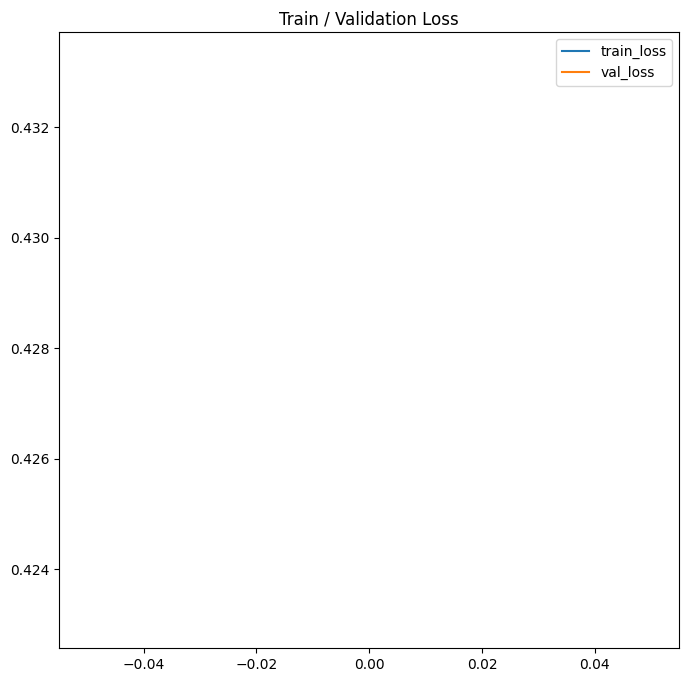

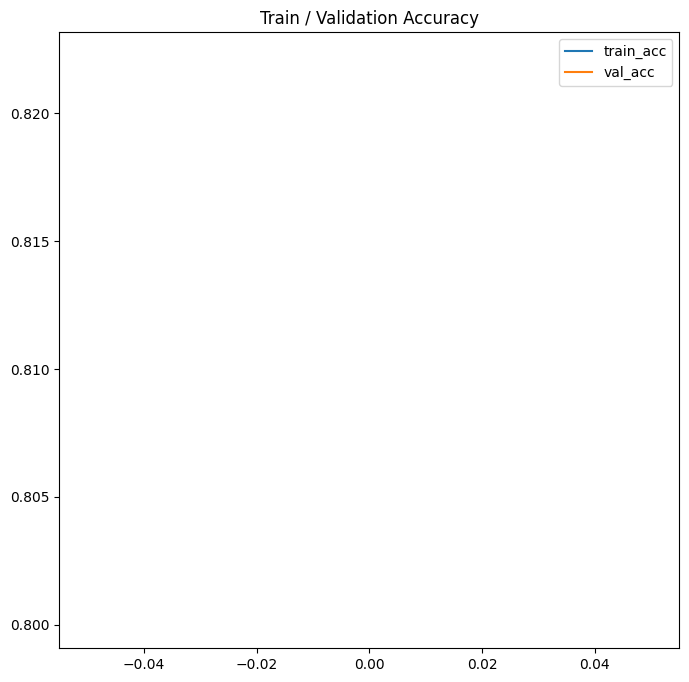

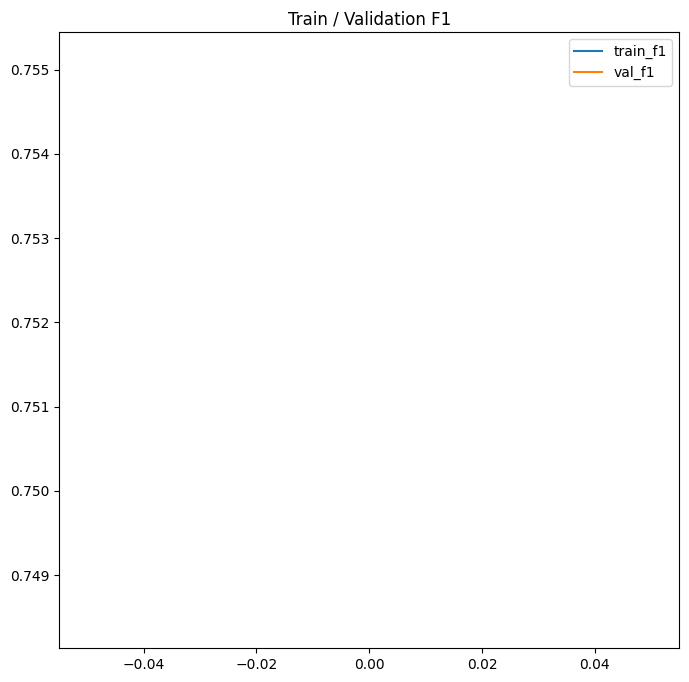

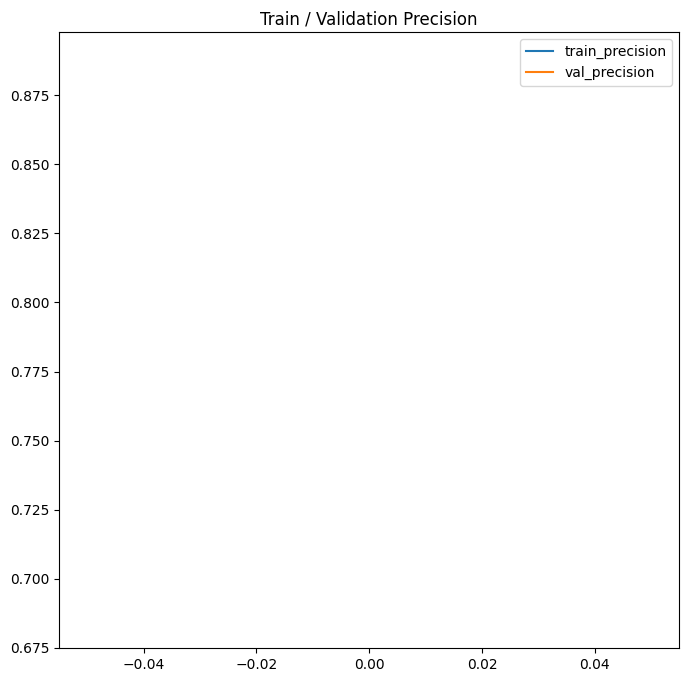

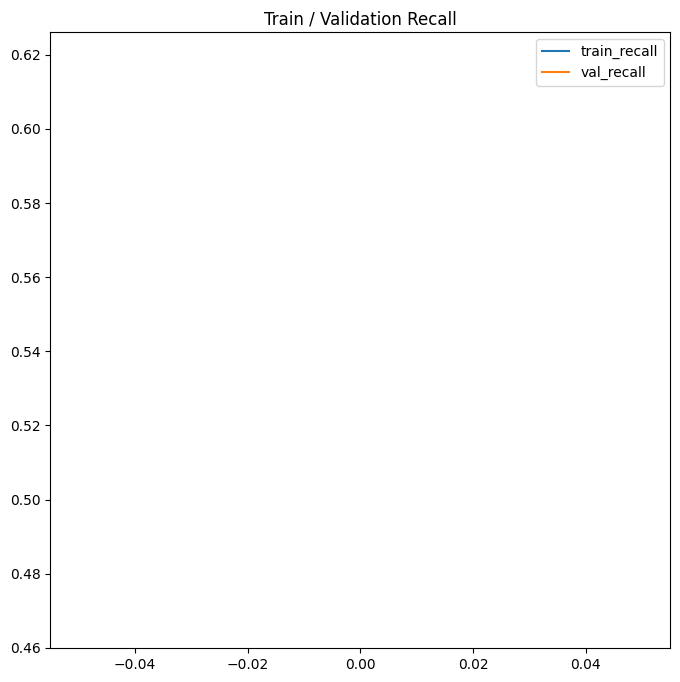

In [31]:
plot_results(history)

In [ ]:
torch.save(base_model.state_dict(), f'{MODELS_PATH}/{DATASET_NAME}_{MODEL_NAME.replace("/", "_")}_{NUM_EPOCHS}.bin')

In [32]:
val_dataset = tokenized_dataset['test']

In [33]:
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=2 * config['batch_size'])

In [34]:
val_loss, val_preds, val_labels = eval_epoch(base_model, val_dataloader)
val_acc = accuracy_score(val_labels, val_preds)
val_f1 = f1_score(val_labels, val_preds, average='macro')
val_precision = precision_score(val_labels, val_preds)
val_recall = recall_score(val_labels, val_preds)

100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


In [35]:
print(f'Val loss: {val_loss / len(val_dataloader)}')
print(f'Val acc: {val_acc}')
print(f'Val f1: {val_f1}')
print(f'Val precision: {val_precision}')
print(f'Val recall: {val_recall}')

Val loss: 0.4230729209052192
Val acc: 0.8220640569395018
Val f1: 0.7484648298333243
Val precision: 0.8876404494382022
Val recall: 0.46745562130177515


## Space Model

In [37]:
base_model = AutoModel.from_pretrained(MODEL_NAME)
base_model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [38]:
space_model = SpaceModelForSequenceClassification(base_model, n_embed=768, n_latent=64, n_concept_spaces=2, l1=0, l2=0, fine_tune=False).to(device)
space_model

SpaceModelForSequenceClassification(
  (base_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,)

In [39]:
count_parameters(space_model)

109580802

In [40]:
ids = val_dataset[0]['input_ids'].unsqueeze(0)
mask = val_dataset[0]['attention_mask'].unsqueeze(0)
targets = val_dataset[0]['label'].unsqueeze(0)

ids = ids.to(device)
mask = mask.to(device)
targets = targets.to(device)

base_embed = space_model.base_model(ids, mask).last_hidden_state

concept_spaces = space_model.space_model(base_embed).concept_spaces

In [41]:
print(f'Inter-space loss: {space_model.l1 * inter_space_loss(concept_spaces) * BATCH_SIZE}')

Inter-space loss: 0.0


In [42]:
print(f'Intra-space loss: {space_model.l2 * intra_space_loss(concept_spaces) * BATCH_SIZE}')

Intra-space loss: 0.0


In [44]:
for p in space_model.base_model.parameters():
    p.requires_grad = False

In [49]:
space_history = training(space_model, tokenized_dataset['train'], tokenized_dataset['val'], config)

Train steps: 140
Epoch: 1


100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


Train loss: 0.2714812860738301 | Val loss: 0.39265987773736316
Train acc: 0.8859746610357857 | Val acc: 0.822380106571936
Train f1: 0.8654269276054015 | Val f1: 0.7933550622504111
Train precision: 0.800862688713156 | Val precision: 0.7
Train recall: 0.8251851851851851 | Val recall: 0.7325581395348837
Initial GPU Usage
GPU memory occupied: 3857 MB.
GPU Usage after emptying the cache
GPU memory occupied: 3089 MB.


In [ ]:
plot_results(space_history)

In [50]:
val_loss, val_preds, val_labels = eval_epoch(space_model, val_dataloader)

100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


In [51]:
val_acc = accuracy_score(val_labels, val_preds)
val_f1 = f1_score(val_labels, val_preds, average='macro')
val_precision = precision_score(val_labels, val_preds)
val_recall = recall_score(val_labels, val_preds)

In [52]:
print(f'Val loss: {val_loss / len(val_dataloader)}')
print(f'Val acc: {val_acc}')
print(f'Val f1: {val_f1}')
print(f'Val precision: {val_precision}')
print(f'Val recall: {val_recall}')

Val loss: 0.4060312360525131
Val acc: 0.8309608540925267
Val f1: 0.7993724517595776
Val precision: 0.7176470588235294
Val recall: 0.7218934911242604


In [ ]:
torch.save(space_model.state_dict(), f'{MODELS_PATH}/{DATASET_NAME}_space-{MODEL_NAME}_{NUM_EPOCHS}.bin')

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ <ipython-input-140-79affbd18766>:1 in <module>                                                   │
│                                                                                                  │
│ /usr/local/lib/python3.8/dist-packages/torch/serialization.py:440 in save                        │
│                                                                                                  │
│    437 │   _check_save_filelike(f)                                                               │
│    438 │                                                                                         │
│    439 │   if _use_new_zipfile_serialization:                                                    │
│ ❱  440 │   │   with _open_zipfile_writer(f) as opened_zipfile:                                   │
│    441 │   │   │   _save(obj, opened_zipfile, pickle_module, pickle_protocol)                    │
│    442 │   │   │   return                                                                        │
│    443 │   else:                                                                                 │
│                                                                                                  │
│ /usr/local/lib/python3.8/dist-packages/torch/serialization.py:315 in _open_zipfile_writer        │
│                                                                                                  │
│    312 │   │   container = _open_zipfile_writer_file                                             │
│    313 │   else:                                                                                 │
│    314 │   │   container = _open_zipfile_writer_buffer                                           │
│ ❱  315 │   return container(name_or_buffer)                                                      │
│    316                                                                                           │
│    317                                                                                           │
│    318 def _is_compressed_file(f) -> bool:                                                       │
│                                                                                                  │
│ /usr/local/lib/python3.8/dist-packages/torch/serialization.py:288 in __init__                    │
│                                                                                                  │
│    285                                                                                           │
│    286 class _open_zipfile_writer_file(_opener):                                                 │
│    287 │   def __init__(self, name) -> None:                                                     │
│ ❱  288 │   │   super().__init__(torch._C.PyTorchFileWriter(str(name)))                           │
│    289 │                                                                                         │
│    290 │   def __exit__(self, *args) -> None:                                                    │
│    291 │   │   self.file_like.write_end_of_file()                                                │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
RuntimeError: Parent directory models/glue_space-microsoft does not exist.

### Interpretation

In [ ]:
test_dataset = tokenized_dataset['unsupervised']

In [ ]:
# examples with less than 16 words are easier to visualize, so focus on them
examples_ids = []
for i, v in enumerate(list(test_dataset['input_ids'])):
    s = [t for t in v.cpu() if t != tokenizer.pad_token_id]
    if len(s) <= 16:
        examples_ids.append(i)
print(examples_ids)

[8132, 37527, 46980]


In [ ]:
scatters = []
colors = ['blue', 'red']
for sample_index in examples_ids:
    # extract example, decode to tokens and get the sequence length (ingoring padding)
    test_tokenized_batch = test_dataset[sample_index]
    tokens = [tokenizer.decode(t) for t in test_tokenized_batch['input_ids'] if t != tokenizer.pad_token_id]
    seq_len = len(tokens)

    input_ids = test_tokenized_batch['input_ids'].to(device).unsqueeze(0)
    attention_mask = test_tokenized_batch['attention_mask'].to(device).unsqueeze(0)

    base_embed = space_model.base_model(input_ids, attention_mask).last_hidden_state

    concept_spaces = space_model.space_model(base_embed).concept_spaces

    print()

    for c, embed in enumerate(concept_spaces):
        x, y, z = embed[0, :seq_len, 0].detach().cpu().numpy(), embed[0, :seq_len, 1].detach().cpu().numpy(), embed[0, :seq_len, 2].detach().cpu().numpy()

        scatters.append(go.Scatter3d(
            x=x, y=y, z=z, mode='markers+text',
            name=f'Example: {sample_index} ({c})',
            text=tokens,
            marker=dict(color=colors[c]),
            # hovertext=[]
        ))

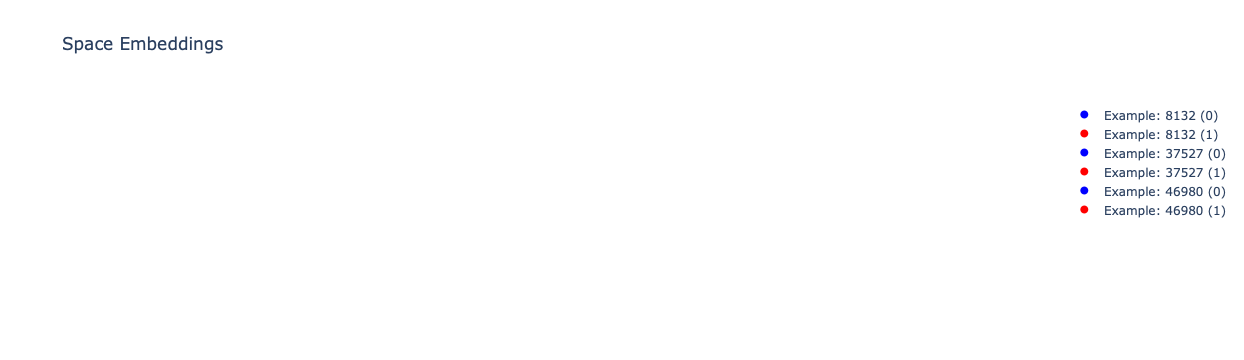

In [ ]:
fig = go.Figure(
    data=scatters,
    layout=go.Layout(
        title=go.layout.Title(text='Space Embeddings')
    ))
fig.show()

In [ ]:
fig.write_html(f'plots/{DATASET_NAME}_space-{MODEL_NAME}_{NUM_EPOCHS}.html')

In [ ]:
# space_bert = SpaceBertForSequenceClassification(bert, n_embed=768, n_latent=3, n_concept_spaces=2, l1=0, l2=0).to(device)
# space_bert.load_state_dict(torch.load(f'{MODELS_PATH}/ce_loss_2_epochs.bin'))
# space_bert